In [3]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa, iqm, coherentReceiver
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.comm.sources import bitSource
from optic.dsp.core import upsample, pulseShape, pnorm, anorm, signalPower
from optic.comm.metrics import calcEVM

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram, pconst
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
np.random.seed(seed=123) # fixing the seed to get reproducible results

In [6]:
"""
Single-channel QPSK coherent transmitter using OptiCommPy's IQM
(patterned after optic.models.tx.simpleWDMTx).

What you get:
- symbTx: QPSK symbols (unit-energy constellation by design)
- sigTx: pulse-shaped complex baseband (normalized to peak amplitude 1)
- sigLO: complex optical carrier field (unit amplitude, optional phase noise)
- sigTxo: modulated optical field at the transmitter output, with desired launch power

Key OptiCommPy conventions (same as simpleWDMTx):
1) Peak-normalize the pulse-shaped waveform: sigTx /= max(|sigTx|)
2) Drive IQM with a dimensionless "normalized voltage": u = mzmScale * sigTx
   where mzmScale is the modulation-depth knob (documented as ~ Vrf/Vpi).
3) Set actual launched optical power AFTER modulation:
   sigTxo = sqrt(P_launch) * pnorm(sigTxo)
"""
# -------------------------
# 1) User parameters
# -------------------------
SpS = 16              # samples per symbol
Rs = 10e9             # symbol rate [baud]
Fs = Rs * SpS         # sampling frequency [Hz]
M = 4                 # QPSK -> M=4, constType='psk'
nBits = 100000        # total bits to generate
rollOff = 0.01        # RRC roll-off
nFilterTaps = 1024    # RRC filter taps

mzmScale = 0.5        # IQM drive scale (OptiCommPy default)
P_launch_dBm = 0      # desired launched optical power [dBm]
laserLinewidth = 0    # Hz (set e.g. 100e3 for phase noise), setting laserLineWidth to 0, models the ideal case 
seed = 12335          # RNG seed


# -------------------------
# 2) Symbol generation (QPSK)
# -------------------------
# In OptiCommPy, symbolSource() generates constellation symbols.
# With constType='psk' and M=4 -> QPSK. The symbol sequence is complex.
# paramSymb = parameters()
# paramSymb.nSymbols = int(nBits // np.log2(M))  # symbols = bits / log2(M)
# paramSymb.M = M
# paramSymb.constType = "psk"                    # 'psk' with M=4 -> QPSK
# paramSymb.dist = "uniform"                     # uniform symbol probabilities
# paramSymb.seed = seed
#symbTx = symbolSource(paramSymb)               # shape: (nSymbols,)

# ===================================
# 2) Bit source parameters
paramBits = parameters()
paramBits.nBits = 100000  # number of bits to be generated
paramBits.mode = 'prbs'   # mode of the bit source  
paramBits.order = 23      # order of the PRBS
paramBits.seed = 12335    # seed for the random number generator

# generate pseudo-random bit sequence
bitsTx = bitSource(paramBits)

# generate 4-QAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')
print(symbTx[:10])


# -------------------------
# 3) Upsampling + pulse shaping (RRC)
# -------------------------
# Upsampling inserts SpS-1 zeros between symbols, then FIR filtering applies RRC.
paramPulse = parameters()
paramPulse.pulseType = "rrc"
paramPulse.nFilterTaps = nFilterTaps
paramPulse.rollOff = rollOff
paramPulse.SpS = SpS

pulse = pulseShape(paramPulse)                 # RRC impulse response

symbolsUp = upsample(symbTx, SpS)              # shape: (nSymbols*SpS,)
sigTx = firFilter(pulse, symbolsUp)            # pulse-shaped baseband waveform

sigTx_ = sigTx

# IMPORTANT: match simpleWDMTx() exactly:
# normalize waveform to peak amplitude 1 (NOT RMS). This makes drive scaling predictable.
sigTx = sigTx / np.max(np.abs(sigTx)) # + 1e-30


# -------------------------
# 4) Optical carrier / LO field (Ein)
# -------------------------
# OptiCommPy's simpleWDMTx creates a unit-amplitude optical field with optional phase noise:
# Ein(t) = exp(j*phi_pn(t)). This is then IQ-modulated.
if laserLinewidth and laserLinewidth > 0:
    phi_pn = phaseNoise(laserLinewidth, len(sigTx), 1 / Fs, seed=seed)
    sigLO = np.exp(1j * phi_pn)
else:
    sigLO = np.ones_like(sigTx, dtype=complex)


# -------------------------
# 5) IQ modulation using IQM
# -------------------------
# Drive signal u(t) is dimensionless in this convention:
# u(t) = mzmScale * sigTx(t)
# mzmScale is the "modulation depth" knob (documented as ~ Vrf/Vpi).
u_drive = mzmScale * sigTx
sigTxo = iqm(sigLO, u_drive)   # complex optical field at IQM output (still normalized power)


# -------------------------
# 6) Set launched optical power
# -------------------------
# pnorm() normalizes the optical field so that mean(|E|^2)=1.
# Then multiplying by sqrt(P) sets mean optical power to P (watts).
P_launch_W = dBm2W(P_launch_dBm)
sigTxo = np.sqrt(P_launch_W) * pnorm(sigTxo)


# -------------------------
# 7) Quick sanity checks
# -------------------------
print("nSymbols =", len(symbTx))
print("Waveform length =", len(sigTx), "samples")
print("Fs =", Fs/1e9, "GHz")
print("Drive max|u| =", np.max(np.abs(u_drive)))      # should be ~ mzmScale (since peak(sigTx)=1)
print("Launch power (W) ~", np.mean(np.abs(sigTxo)**2), "(target:", P_launch_W, ")")

[-1.+1.j -1.+1.j -1.+1.j -1.+1.j  1.+1.j -1.-1.j -1.+1.j -1.+1.j  1.+1.j
  1.+1.j]
nSymbols = 50000
Waveform length = 800000 samples
Fs = 160.0 GHz
Drive max|u| = 0.5
Launch power (W) ~ 0.0010000000000000154 (target: 0.001 )


(np.float64(-1.1), np.float64(1.1), np.float64(-1.1), np.float64(1.1))

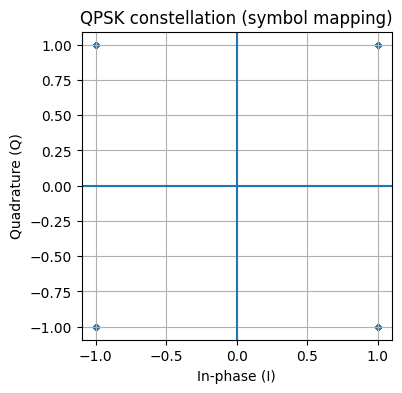

In [43]:
# CONSTELLATION DIAGRAM AFTER SYMBOL MAPPING WITH MY OWN FUNCTION

# plotting constellation diagram after symbol mapping
plt.figure(figsize=(4,4))
plt.scatter(np.real(symbTx), np.imag(symbTx), s=10)
plt.axhline(0); plt.axvline(0)
plt.grid(True)
plt.title("QPSK constellation (symbol mapping)")
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.axis("equal")

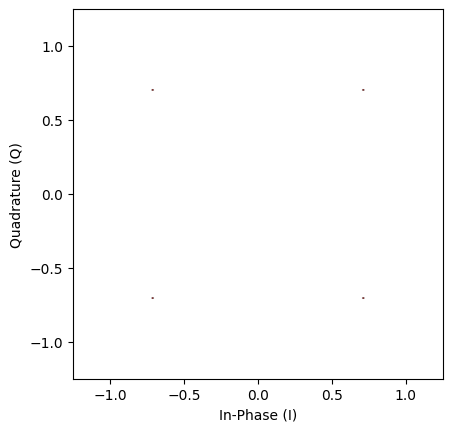

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [61]:
# CONSTELLATION DIAGRAM AFTER SYMBOL MAPPING WITH OPTICOMMPY LIBRARY FUNCTION

# plotting constellation diagram after symbol mapping
pconst(symbTx, lim=True, R=1.25, pType='fancy', cmap='turbo', whiteb=True)

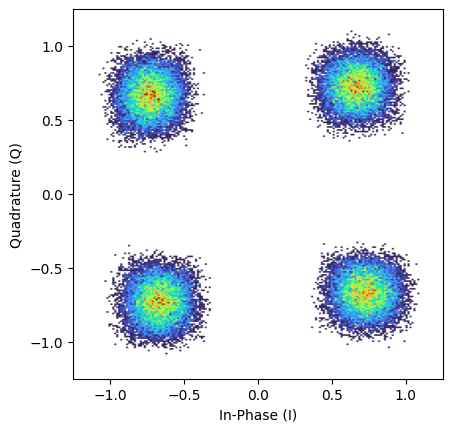

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [ ]:
# CONSTELLATION DIAGRAM AFTER PULSE SHAPING (DAC) -> ANALOGUE WAVEFORM

# after pulse shapping
gd = (paramPS.nFilterTaps - 1)//2
discard = gd + 200*SpS
z = sigTx[discard:-discard]
z_sym = z[::SpS]

# remove scale/rotation for display
n = min(len(z_sym), len(symbTx))
g = np.vdot(symbTx[:n], z_sym[:n]) / np.vdot(symbTx[:n], symbTx[:n])
z_eq = z_sym / g

pconst(z_eq, lim=True, R=1.25, pType='fancy')

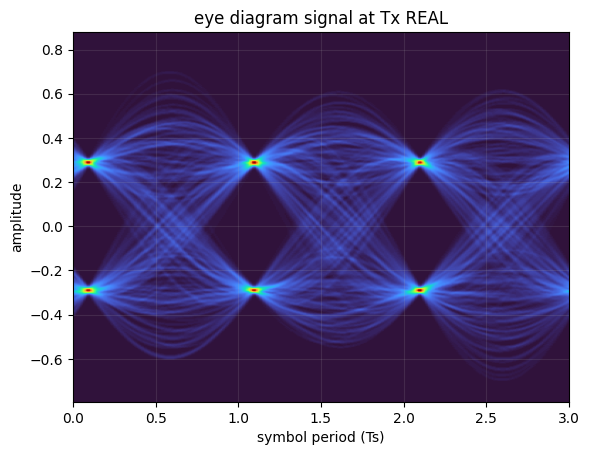

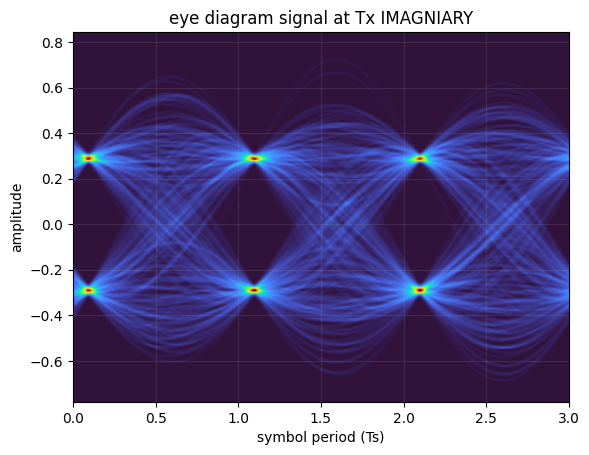

'\nThe Eye Diagrams for both I and Q axis are plotted. \nThe amplitude swings between -0.3 and +0.3, effectively crossing the 0-axix and creating an eye height of 0.6\nEach Eye Diagram therefore has 2 distinct amplitude levels: 2 * 2 = 4 symbols, thereofre validating the QPSK configuration of the system\nThe Eye Diagrams are evaluated at the Tx side (before optical modulation) to ensure that the transmitted signal meets the criteria before entering the channel\n'

In [46]:
# EYE DIAGRAMS AFTER PULSE SHAPPING AND BEFORE IQM

# plotting eye diagrams of sigTx
iscard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigTx.real[discard:-discard], sigTx.real.size-2*discard, SpS, plotlabel='signal at Tx REAL', ptype='fancy')
eyediagram(sigTx.imag[discard:-discard], sigTx.imag.size-2*discard, SpS, plotlabel='signal at Tx IMAGNIARY', ptype='fancy')

# ==== Plot validation ====
"""
The Eye Diagrams for both I and Q axis are plotted. 
The amplitude swings between -0.3 and +0.3, effectively crossing the 0-axix and creating an eye height of 0.6
Each Eye Diagram therefore has 2 distinct amplitude levels: 2 * 2 = 4 symbols, thereofre validating the QPSK configuration of the system
The Eye Diagrams are evaluated at the Tx side (before optical modulation) to ensure that the transmitted signal meets the criteria before entering the channel
"""

In [66]:
# CREATING TIME INTERVAL FOR PSD AND TIME PLOTS

# interval and time
interval = np.arange(16*20, 16*50)
t = interval * Ts / 1e-9

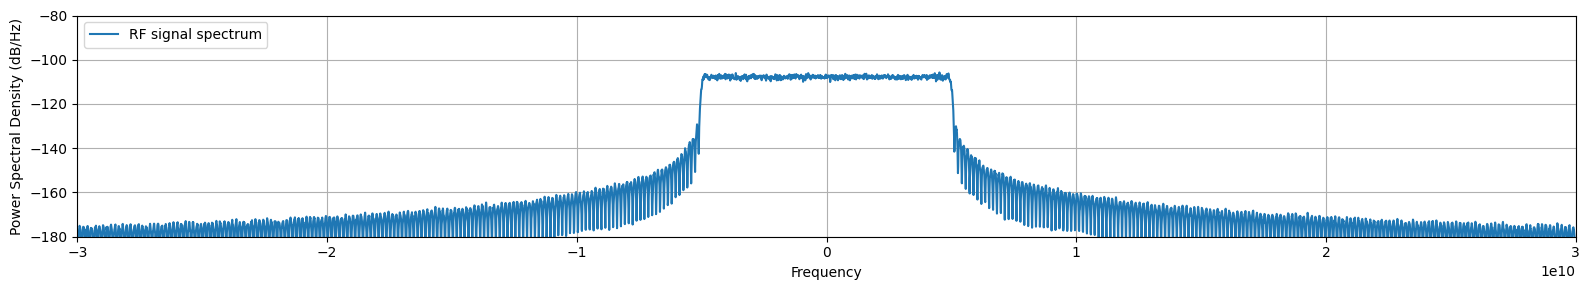

'\nThe RRC Filter Spectrum has a bandwidth of: B = Rs/2 * (1 + a)\nTherefore the theoretical/expected bandwidth is B = 10e9/2 * (1+0.01) = 5.05*10e8 Herz\nFrom the graph we read off aproximately 0.5 * 1e10  Herz\nAs a result theory matches expectation\n\nIt is important to mention the effect of the size of the FFT (N) in pulse shapping. \nA higher N leads to:\n       - higher accuracy\n       - reduced side lobes (out of band emissions)\n       - minimized ISI by decreasing corss-talk between adjacent symbols\n       - increases computational complexity and effort\nAs a conclusion: a larger FFT allows for more precise frequenct-domain shaping, creating a tigher (more dense spectrum) \nand less interference, but increases the computational load\n'

In [7]:
# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-180, -80)
ax.psd(sigTx, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='RF signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# ==== Plot validation ====
"""
The RRC Filter Spectrum has a bandwidth of: B = Rs/2 * (1 + a)
Therefore the theoretical/expected bandwidth is B = 10e9/2 * (1+0.01) = 5.05*10e8 Herz
From the graph we read off aproximately 0.5 * 1e10  Herz
As a result theory matches expectation

It is important to mention the effect of the size of the FFT (N) in pulse shapping. 
A higher N leads to:
       - higher accuracy
       - reduced side lobes (out of band emissions)
       - minimized ISI by decreasing corss-talk between adjacent symbols
       - increases computational complexity and effort
As a conclusion: a larger FFT allows for more precise frequenct-domain shaping, creating a tigher (more dense spectrum) 
and less interference, but increases the computational load
"""


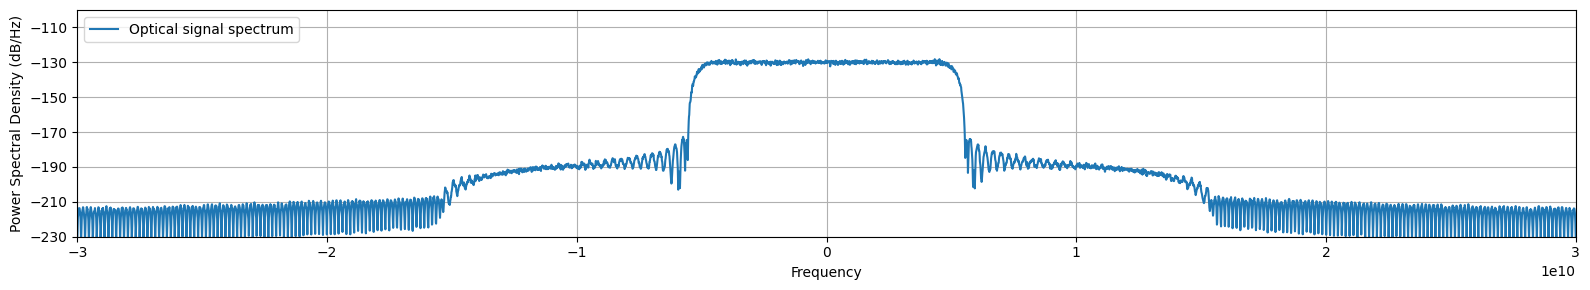

In [79]:
# ===== Optical PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

# switch between sigTxo and np.abs(sigTxo)**2

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-230, -100)
ax.psd(sigTxo, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='Optical signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

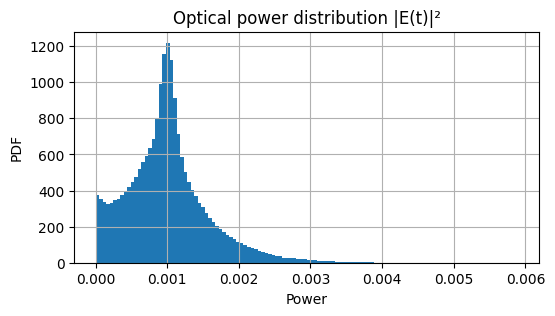

In [69]:
# ===== Optical Power Histogram =====
Pmid = np.abs(sigTxo)**2
Pmid = Pmid[discard:-discard]

plt.figure(figsize=(6,3))
plt.hist(Pmid, bins=120, density=True)
plt.title("Optical power distribution |E(t)|²")
plt.xlabel("Power"); plt.ylabel("PDF")
plt.grid(True)

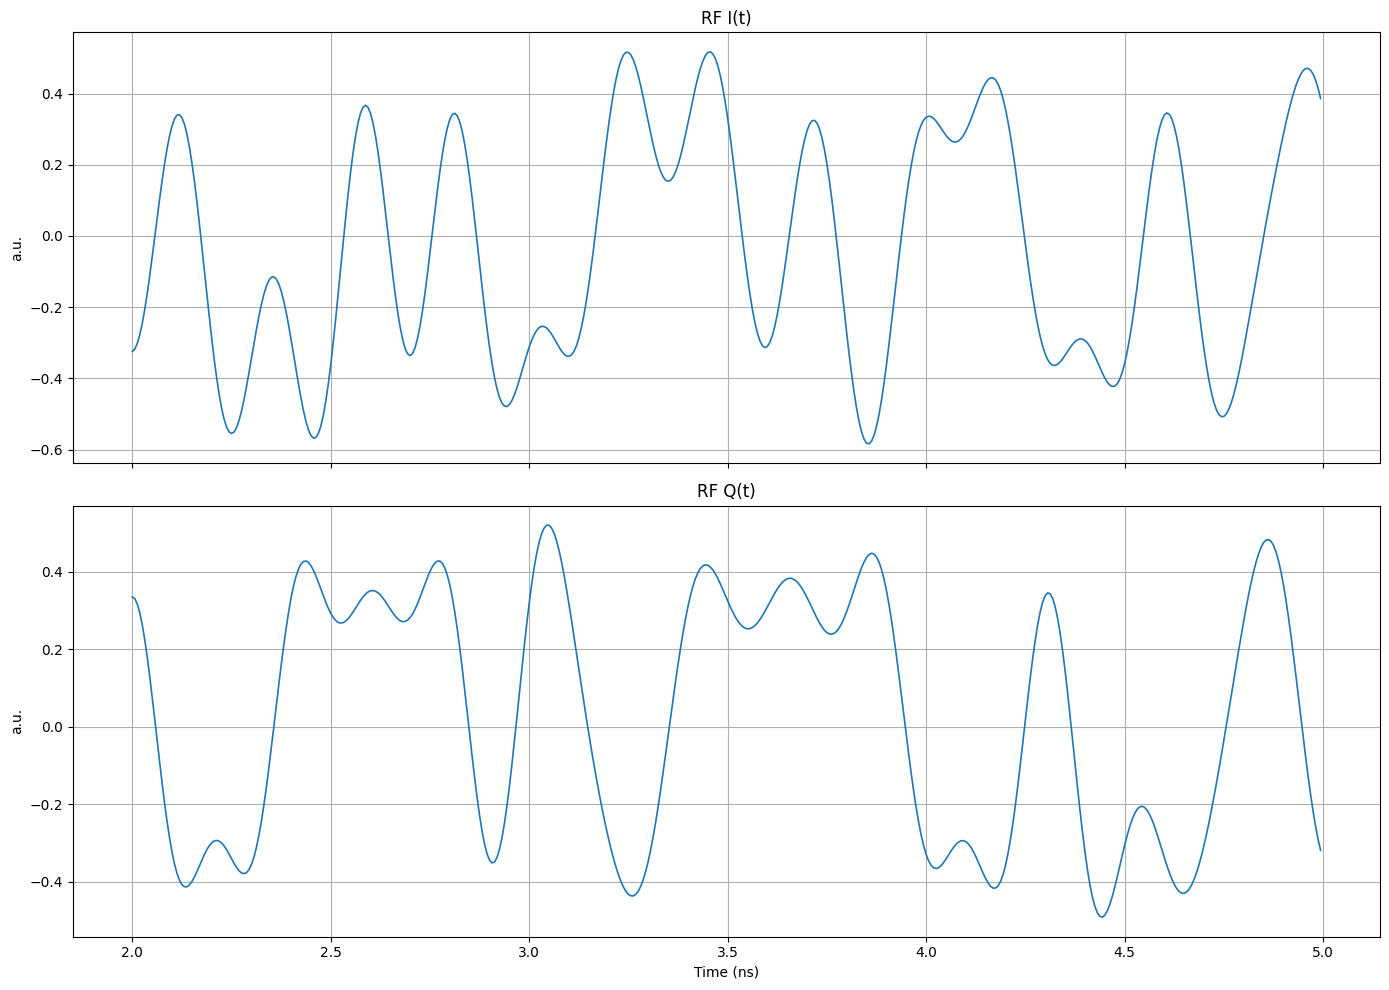

In [80]:
# ===== Electrical Waveform Real and Imaginary Part Vs Time =====
fig, axs = plt.subplots(2, 1, figsize=(14,10), sharex=True)
axs[0].plot(t, np.real(sigTx[interval]), linewidth=1.2)
axs[0].set_title("RF I(t)")
axs[1].plot(t, np.imag(sigTx[interval]), linewidth=1.2)
axs[1].set_title("RF Q(t)")
for ax in axs:
    ax.grid(True)
    ax.set_ylabel("a.u.")

axs[-1].set_xlabel("Time (ns)")
plt.tight_layout()